### Directory Checking

In [1]:
%cd /kaggle/input/plantdisease
!ls
%cd /kaggle/working
!ls

/kaggle/input/plantdisease
PlantVillage  plantvillage
/kaggle/working
__notebook_source__.ipynb


#  >***EfficientNet***
* PyTorch Implementation
* efficientnet-torch

In [2]:
!git clone https://github.com/lukemelas/EfficientNet-PyTorch
%cd ./EfficientNet-PyTorch
!pip install -e 

Cloning into 'EfficientNet-PyTorch'...
remote: Enumerating objects: 665, done.
remote: Counting objects: 100% (70/70), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 665 (delta 26), reused 58 (delta 23), pack-reused 595
Receiving objects: 100% (665/665), 1.14 MiB | 10.08 MiB/s, done.
Resolving deltas: 100% (341/341), done.
/kaggle/working/EfficientNet-PyTorch

Usage:   
  pip install [options] <requirement specifier> [package-index-options] ...
  pip install [options] -r <requirements file> [package-index-options] ...
  pip install [options] [-e] <vcs project url> ...
  pip install [options] [-e] <local project path> ...
  pip install [options] <archive url/path> ...

-e option requires 1 argument


### Import Packages

In [ ]:
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import torch    #Main Module
import torch.nn as nn #contains neural network classes
import torch.nn.functional as F #functional interface to nn op
import torch.optim as optim  #optimizting alg
from torch.optim import lr_scheduler #learning rate schedulers for the opt alg
import torchvision   # provides access to popular datasets, model architectures, and image transformations for computer vision tasks
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader

from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

import numpy as np
import random
import time
import copy

# > ***Ckecks whether a CUDA-enabled GPU is available on the system***

In [4]:
import torch

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

print(torch.cuda.is_available())

!nvidia-smi #check GPU

True
Mon May  1 13:36:09 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8     9W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla T4            Off  | 00000000:00:05.0 Off |                    0 |
| N

# > ***ImageFolder***
* calculate :Mean,Std 

In [5]:
batch_size = 64

data_path = '/kaggle/input/plantdisease/PlantVillage'
#object is used to represeny a ds of images
leaf_datasets = datasets.ImageFolder(
    data_path,
    #include resize the image to 224*224 pixels
    #conerting the images to tensor
    transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
)

# > ***Data Split***
* Train (60) / Valid(20) / Test

In [6]:
random_seed = 33
#to ensure the random number generator generates
#the same sequence of random numbers each time
#the code is run, 
#which can help ensure reproducible results.
random.seed(random_seed)
torch.manual_seed(random_seed)

dataset = {}
#combine validation and testing 
train_idx, valtest_idx = train_test_split(list(range(len(leaf_datasets))), test_size=0.4, random_state=random_seed)
dataset['train'] = Subset(leaf_datasets, train_idx)
valtest          = Subset(leaf_datasets, valtest_idx)

#separate validation and testing subsets
val_idx, test_idx = train_test_split(list(range(len(valtest))), test_size=0.5, random_state=random_seed)
dataset['valid'] = Subset(valtest, val_idx)
dataset['test']  = Subset(valtest, test_idx)

In [7]:
print(len(dataset['train']))
print(len(dataset['valid']))

12382
4128


In [8]:
#each loader is created with specific batch size
#Shuffle:to randomly shuffle the data during each epoch
#num_workers:sets the number of worker threads to use for loading the data
dataloaders, batch_num = {}, {}
dataloaders['train'] = DataLoader(dataset['train'],
                                  batch_size=batch_size, shuffle=True,
                                  num_workers=8)
dataloaders['valid'] = DataLoader(dataset['valid'],
                                  batch_size=batch_size, shuffle=True,
                                  num_workers=8)
dataloaders['test'] = DataLoader(dataset['test'],
                                  batch_size=batch_size, shuffle=True,
                                  num_workers=8)


batch_num['train'], batch_num['valid'], batch_num['test'] = len(dataloaders['train']), len(dataloaders['valid']), len(dataloaders['test'])
print('batch_size : %d,  test/valid/test : %d / %d / %d' % (batch_size, batch_num['train'], batch_num['valid'], batch_num['test']))

batch_size : 64,  test/valid : 194 / 65 / 65


# > ***Class Distribution Check***

In [9]:
#counts the no of imgs in each class of a PyTorch ds
#count & v_count : count the no of imgs in each of the 15 classes in the ds
#                  rep the dist of images across the classes in the trainig & validation
count = np.zeros(15)

for images, labels in dataloaders['train']:  
    for a in labels:
      count[a.numpy()] += 1

print(count)


v_count = np.zeros(15)

for images, labels in dataloaders['valid']:  
    for a in labels:
      v_count[a.numpy()] += 1

print(v_count)

[ 599.  867.  571.  592.  102. 1302.  616. 1143.  593. 1088. 1025.  869.
 1875.  210.  930.]
[182. 316. 212. 210.  23. 396. 199. 400. 171. 335. 329. 283. 661.  79.
 332.]


torch.Size([3, 224, 224])


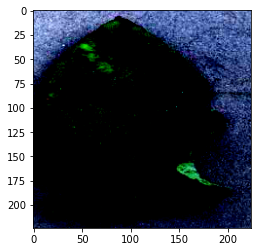

In [10]:
imgtest = None
for images, labels in dataloaders['train']:  
    imgtest = images[3]
    print(imgtest.shape)
    break

imgtest = imgtest.numpy()
imgtest = np.moveaxis(imgtest, 0, -1)
imshow(imgtest)

In [11]:
%cd /kaggle/working/EfficientNet-PyTorch

from efficientnet_pytorch import EfficientNet
# model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=15)
model = EfficientNet.from_name('efficientnet-b0', num_classes=15)

for param in model.parameters():
    param.requires_grad = True
#cuda: indicates that the model will be trained on a GPU if one is available.
dev = torch.device("cuda") 

/kaggle/working/EfficientNet-PyTorch


In [12]:
#dev = cuda
model = model.to(dev)
#optim.SGD: update the parameters 
optimizer = optim.SGD(model.parameters(), 
                         lr = 0.0005,
                         momentum=0.9,
                         weight_decay=1e-4)
#compute the loss during training
criterion = nn.CrossEntropyLoss()

# > ***Training***
* train and validation is done in one epoch
* trace train , val acc scores and losses
* save the model which has the highest validation acc


* total number of train data = 12382
* train acc = corrects / 12382 * 100 = corrects * **0.008**
* total number of validation data = 4128
* val acc = corrects / 4128 * 100 = corrects * **0.0242**

 * The optimizer is then used to update the model parameters based on the loss
 * The training and validation accuracies are calculated using the number of correct predictions and the total number of samples in the dataset.
 

In [13]:
num_epochs = 70
trn_loss_list, val_loss_list, trn_acc_list, val_acc_list = [], [], [], []
best_acc = 0.0

since = time.time()
# creates a copy of the current state of the neural network
#(Weight & bias)
#used later if the model achieves the best validation accuracy
best_model = copy.deepcopy(model.state_dict()) #by7fz el acc


for epoch in range(num_epochs):               x
    trn_loss, trn_corrects, val_loss, val_corrects = 0.0, 0, 0.0, 0
    
    model.train()
    #for images and their corresponding labels
    for i, (data, target) in enumerate(dataloaders['train']):
        #moves the data and labels to the device
        data, target = data.to(dev), target.to(dev)

        optimizer.zero_grad()
        output = model(data)                
    
        #calculates the loss between the predicted outputs and the true labels 
        loss = criterion(output, target)
        loss.backward()
        
        #update the model's parameters 
        optimizer.step()  
        
        #calculate the number of correct predictions, training loss, 
        #and training accuracy for the current batch of training data.
        _, preds = torch.max(output, 1)
        trn_corrects += torch.sum(preds == target.data)
        trn_loss += loss.item()
    model.eval()
    with torch.no_grad():
        for j, (val_data, val_target) in enumerate(dataloaders['valid']):
            val_data, val_target = val_data.to(dev), val_target.to(dev)
            
            val_output = model(val_data)
            v_loss = criterion(val_output, val_target)
            
            _, preds = torch.max(val_output, 1)
            val_corrects += torch.sum(preds == val_target.data)
            val_loss += v_loss.item()


    trn_acc_list.append(trn_corrects * 0.008)
    val_acc_list.append(val_corrects * 0.0242)
    trn_loss_list.append(trn_loss/batch_num['train'])
    val_loss_list.append(val_loss/batch_num['valid'])

    time_elapsed = time.time() - since
    print("epoch: {}/{} | trn loss: {:.4f} | val loss: {:.4f} | {:.0f}m {:.0f}s elapsed".format(
                epoch+1, num_epochs, trn_loss / batch_num['train'], val_loss / batch_num['valid'], 
                time_elapsed // 60, time_elapsed % 60))

    if val_corrects * 0.0242 > best_acc:
      best_acc = val_corrects * 0.0242
      best_model = copy.deepcopy(model.state_dict())
      print("best model updated-epoch: {} | val_accuracy: {:.4f}".format(epoch+1, best_acc))


time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
print('Best valid Acc: %.1f' %(best_acc))

model.load_state_dict(best_model)
torch.save(model.state_dict(), '/kaggle/working/best_model.pt')
print("model saved")

epoch: 1/70 | trn loss: 2.4706 | val loss: 2.6384 | 1m 46s elapsed
best model updated-epoch: 1 | val_accuracy: 15.9962
epoch: 2/70 | trn loss: 2.2641 | val loss: 2.7343 | 3m 33s elapsed
epoch: 3/70 | trn loss: 2.0554 | val loss: 2.8445 | 5m 21s elapsed
best model updated-epoch: 3 | val_accuracy: 16.8190
epoch: 4/70 | trn loss: 1.7733 | val loss: 1.6523 | 7m 8s elapsed
best model updated-epoch: 4 | val_accuracy: 44.9152
epoch: 5/70 | trn loss: 1.5166 | val loss: 1.3369 | 8m 56s elapsed
best model updated-epoch: 5 | val_accuracy: 54.9098
epoch: 6/70 | trn loss: 1.3465 | val loss: 1.1690 | 10m 42s elapsed
best model updated-epoch: 6 | val_accuracy: 61.3954
epoch: 7/70 | trn loss: 1.1921 | val loss: 1.1255 | 12m 28s elapsed
epoch: 8/70 | trn loss: 1.0682 | val loss: 1.0195 | 14m 16s elapsed
best model updated-epoch: 8 | val_accuracy: 66.5742
epoch: 9/70 | trn loss: 0.9365 | val loss: 0.7845 | 16m 2s elapsed
best model updated-epoch: 9 | val_accuracy: 73.9310
epoch: 10/70 | trn loss: 0.8276

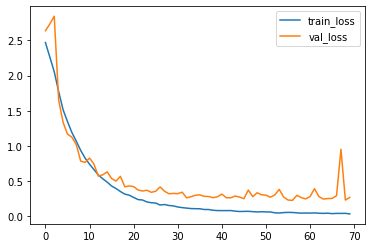

In [14]:
plt.plot(trn_loss_list, label='train_loss')
plt.plot(val_loss_list, label='val_loss')
plt.legend()

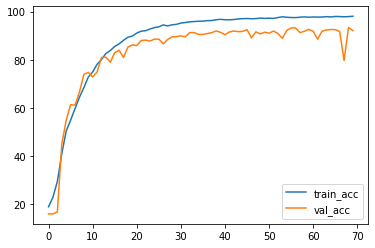

In [15]:
plt.plot(trn_acc_list, label='train_acc')
plt.plot(val_acc_list, label='val_acc')
plt.legend()

In [16]:
best_model = EfficientNet.from_name('efficientnet-b0', num_classes=15)
best_model.load_state_dict(torch.load('/kaggle/working/best_model.pt'))

best_model.to(dev)

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=

In [17]:
corrects = 0
total = 0

model.eval()
with torch.no_grad():
    for j, (data, target) in enumerate(dataloaders['test']):
        data, target = data.to(dev), target.to(dev)

        output = best_model(data)
        
        _, preds = torch.max(output, 1)
        corrects += torch.sum(preds == target.data)
        total += len(preds)
        
print("{}/{} | test accuracy: {:.4f}".format(corrects, total, corrects/total))

3761/4128 | test accuracy: 0.9111
